## Collection_DS_takehome_challenges: Spanish Translation AB Testing

### Kanja Saha
### 10/15/2018

Company XYZ is a worldwide e-commerce site with localized versions of the site.
A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than
any other Spanish-speaking country. She therefore went and talked to the international team in
charge of Spain And LatAm to see if they had any ideas about why that was happening.
Spain and LatAm country manager suggested that one reason could be translation. All Spanishspeaking
countries had the same translation of the site which was written by a Spaniard. They
agreed to try a test where each country would have its one translation written by a local. That is,
Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican
and so on. Obviously, nothing would change for users from Spain.
After they run the test however, they are really surprised cause the test is negative. I.e., it
appears that the non-localized translation was doing better!
You are asked to:
- Confirm that the test is actually negative. That is, it appears that the old version of the
    site with just one translation across Spain and LatAm performs better
- Explain why that might be happening. Are the localized translations really worse?



### 1. Import Libraries & Data Load 

In [1]:
#import necessary libraries
import pandas as pd
from IPython.display import display,Markdown
import seaborn as sns
import matplotlib.pyplot as plt


'''import numpy as np

from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


def printbold(string,df):
    display(Markdown(string),df)'''


'import numpy as np\n\nfrom datetime import datetime\nfrom mpl_toolkits.mplot3d import Axes3D\n%matplotlib inline\n\n\ndef printbold(string,df):\n    display(Markdown(string),df)'

In [2]:
user_table=pd.read_csv("user_table.csv")
test_table=pd.read_csv("test_table.csv")

display(user_table.head())
display(test_table.head())

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [3]:
df=user_table.merge(test_table,on='user_id',how='outer')
df.head()

,user_id,sex,age,country,date,source,device,browser_language,ads_channel,browser,conversion,test
0,765821,M,20.0,Mexico,2015-12-02,Ads,Mobile,ES,Yahoo,Android_App,0,1
1,343561,F,27.0,Nicaragua,2015-12-04,Ads,Web,ES,Facebook,Safari,0,0
2,118744,M,23.0,Colombia,2015-11-30,Ads,Mobile,ES,Facebook,Android_App,0,1
3,987753,F,27.0,Venezuela,2015-12-04,SEO,Web,ES,NaN,IE,0,1
4,554597,F,20.0,Spain,2015-12-04,Direct,Web,ES,NaN,Chrome,0,0


In [4]:
df_d=df[df["test"]==0].groupby(['country'], sort=True).agg({'conversion':'mean'})
df_d.sort_values(['conversion'],ascending=0)

,conversion
country,
Spain,0.079719
El Salvador,0.053554
Nicaragua,0.052647
Costa Rica,0.052256
Colombia,0.052089
Honduras,0.050906
Guatemala,0.050643
Venezuela,0.050344
Peru,0.049914


As stated in the description, spain indeed have a higher conversion with the translated version.

In [5]:
data_test = df[df.country!= "Spain"]

In [6]:
from scipy import stats
stats.ttest_ind(data_test[data_test.test == 1].conversion, data_test[data_test.test == 0].conversion)

Ttest_indResult(statistic=-7.422512095954769, pvalue=1.15144687852198e-13)

The p-value is significant, therefore one can reject the null hypothesis in support of the alternative.

In [7]:
data_test[data_test.test == 1].conversion.mean()

0.043424713982118966

In [8]:
data_test[data_test.test == 0].conversion.mean()

0.04833042316066309

C:\Users\kanja\Anaconda3\envs\py35\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


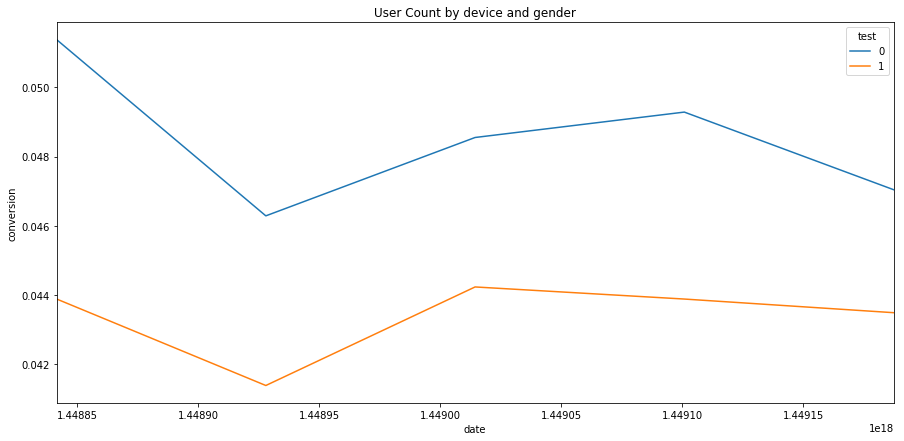

In [9]:
data_test_by_day = data_test.groupby(['date','test']).agg({'conversion':'mean'}).reset_index()
data_test_by_day['date'] = pd.to_datetime(data_test_by_day['date'])

plt.figure(figsize=(15,7))

sns.tsplot(data=data_test_by_day, time="date", unit="test", condition="test", value="conversion")
plt.title("User Count by device and gender")
plt.show()


From the plot, we notice a couple of things:
1. Test has constantly been worse than control and there is relatively little variance across days. That
probably means that we do have enough data, but there was some bias in the experiment set up.
2. On a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to
capture weekly patterns, 2 weeks would be much better.

We also need to check if there is any bias in the dataset, ie.e one group of people is consistengly falling in the test group based on their various attributes.
Likely, there is for some reason some segment of users more likely to end up in test or in control, this segment had a significantly above/below conversion rate and this affected the overall results.




In [36]:
from sklearn.tree import DecisionTreeClassifier,_tree
import numpy as np


data_test_clean=data_test.dropna(axis = 0).reset_index()
dt = data_test_clean.drop('conversion', axis = 1)
samples_1 = len(dt)//5000
#take one percent randomsampling of the data
dt_random_sample_1_percent=dt.sample(n=samples_1)
test_group = dt_random_sample_1_percent['test']
features = dt_random_sample_1_percent.drop('test', axis = 1)
features_d=pd.get_dummies(features)

dtree= DecisionTreeClassifier()
dtree.fit(features_d,test_group)
#clf.tree_.apply(np.asfortranarray(features_d.astype(_tree.DTYPE)))



DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Visualize data

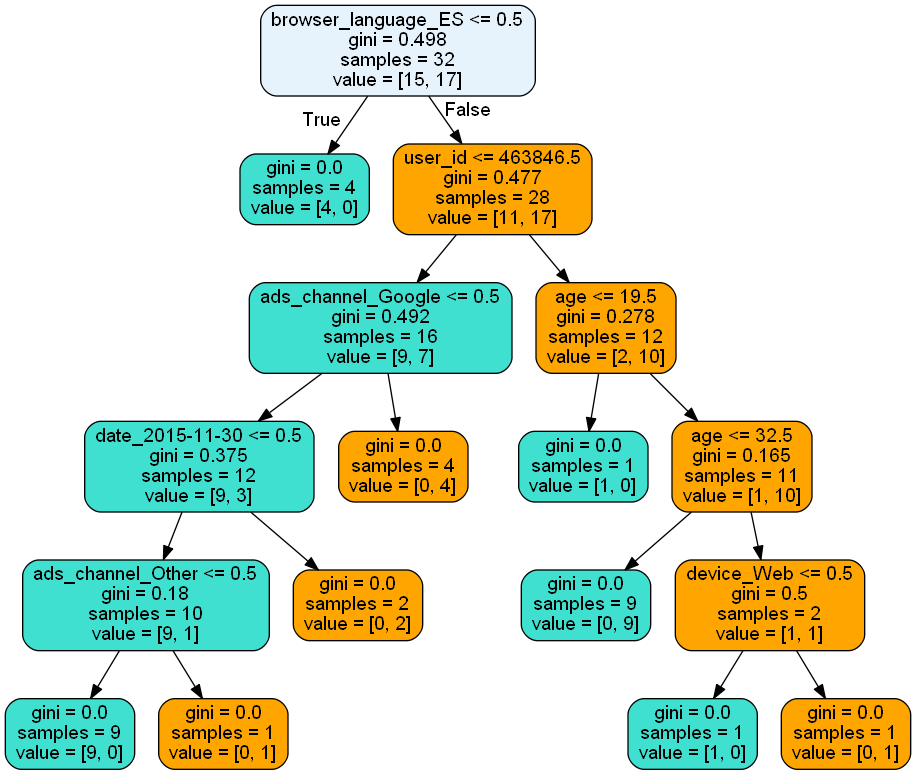

In [37]:
# Visualize data
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn import tree
import pydotplus
import collections
data_feature_names=features_d.columns
dot_data = export_graphviz(dtree,
                                feature_names=data_feature_names,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

Image(graph.create_png())

### ttest By Country

In [30]:
# ttest By Country
#stats.ttest_ind(data_test[data_test.test == 1].conversion, data_test[data_test.test == 0].conversion)
from collections import defaultdict
# get a list of all columns in the dataframe without the Group column
country_list = data_test_clean.country.unique()
# create an empty dictionary
t_test_results = {}
mean ={}
# loop over column_list and execute code explained above
for country in country_list:
    group_test = data_test_clean.where((data_test_clean.test== 1)  & (data_test_clean.country==country)).dropna().conversion
    group_control = data_test_clean.where((data_test_clean.test== 0)  & (data_test_clean.country==country)).dropna().conversion
    #display(group_control.head())
    # add the output to the dictionary 
    t_test_results[country]=(group_test.mean())
    t_test_results[country] = stats.ttest_ind(group_test,group_control)
    mean[country]=group_test.mean(),group_control.mean()
    #group_test.mean(),group_control.mean()
    #t_test_results
    
    
results_df1 = pd.DataFrame.from_dict(t_test_results,orient='Index')
results_df2 = pd.DataFrame.from_dict(mean,orient='Index')
results_df2.columns = ['test mean','test control']
result = results_df1.join(results_df2,  how='inner', lsuffix='', rsuffix='', sort=False)
result

,statistic,pvalue,test mean,test control
Argentina,-0.595245,0.551687,0.013080,0.014324
Paraguay,-0.533296,0.593868,0.047777,0.052027
Peru,-0.355635,0.722119,0.049353,0.050689
Costa Rica,-0.337655,0.735657,0.056550,0.059981
El Salvador,0.069849,0.944318,0.049118,0.048590
Venezuela,0.860625,0.389461,0.049835,0.046590
Colombia,-1.636294,0.101793,0.049520,0.054480
Guatemala,-0.562306,0.573928,0.050545,0.053753
Bolivia,-0.539545,0.589538,0.047001,0.050461
Nicaragua,0.953508,0.340420,0.061033,0.052437
